In [ ]:
import numpy as np
import torch
import torch.distributions as dist
import torch.nn as nn

from abstract_proposal import AbstractProposal


class MixtureOfGaussian(AbstractProposal):
    def __init__(
        self,
        input_size: torch.Size,
        logit_pi: torch.Tensor,
        mu: torch.Tensor,
        sigma: torch.Tensor,
        **kwargs,
    ) -> None:
        super().__init__(input_size=input_size)
        print("Init Standard Gaussian...")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.logit_pi = nn.Parameter(logit_pi, requires_grad=False)
        self.mu = nn.Parameter(mu, requires_grad=False)
        self.sigma = nn.Parameter(sigma, requires_grad=False)
        assert self.logit_pi.shape[0] == self.mu.shape[0]
        assert self.logit_pi.shape[0] == self.sigma.shape[0]
        assert self.mu.shape[1] == self.sigma.shape[1]

    def sample_simple(self, nb_sample=1):
        self.distribution = dist.Normal(self.mu, self.sigma)
        samples = self.distribution.sample((nb_sample,))
        sample_choice = torch.distributions.Categorical(logits=self.logit_pi).sample(
            (nb_sample,)
        )
        sample_choice = sample_choice.unsqueeze(1)
        sample_choice = torch.cat(
            [sample_choice == k for k in range(self.logit_pi.shape[0])], dim=1
        ).unsqueeze(-1)
        samples = (sample_choice * samples).sum(1)

        return samples

    def log_prob_simple(self, x):
        self.distribution = dist.Normal(self.mu, self.sigma)
        x = x.to(self.device)
        x = x.unsqueeze(1).expand(-1, self.logit_pi.shape[0], -1)
        log_prob = self.distribution.log_prob(x).sum(-1)
        log_prob = log_prob + torch.nn.functional.log_softmax(self.logit_pi, dim=0)
        log_prob = torch.logsumexp(log_prob, dim=1)
        return log_prob


In [ ]:
input_size = torch.Size([1])

mixture = MixtureOfGaussian(
    input_size=torch.Size([1]),
    logit_pi=torch.tensor([0.5, 0.5]),
    mu=torch.tensor([[-10.0], [10.0],]),
    sigma=torch.tensor([[1.0], [1.0],]),
)

Init Standard Gaussian...


In [ ]:
aux = mixture.sample_simple(10)

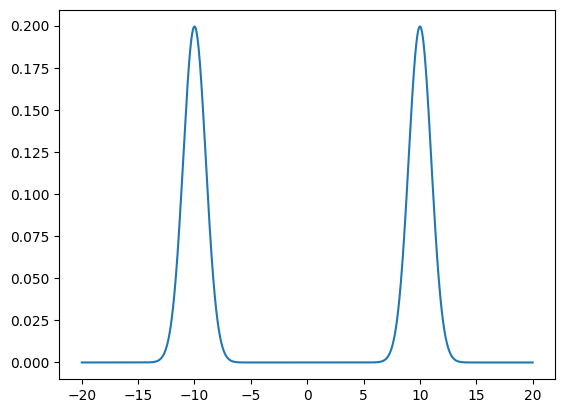

tensor(0.9999)

In [ ]:
x_range = torch.linspace(-20, 20, 10000).unsqueeze(1)
log_prob = mixture.log_prob_simple(x_range)
import matplotlib.pyplot as plt

plt.plot(x_range, torch.exp(log_prob))
plt.show()

(log_prob.exp()* (40 / 10000)).sum()
